# Testing script

This script:  
1. Takes an input list of PDB ID + chain ID
2. Processes each structure specified by point **1** to a distance matrix
3. Loads and uses a given model to make predictions based on the distance matrix from point **2**
4. Adds together the predictions from point **3** and compares them to ground truth labels
5. Outputs measures of model performance: Precision, Recall, F1-Score, and MCC for SOLeNNoID and comparison models
---

## Imports

In [12]:
import math
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Average
from tensorflow.keras import backend as K
import tensorflow as tf
from Bio.PDB import *
from math import ceil
#from tensorflow.python.compiler.mlcompute import mlcompute
#import tensorflow_addons as tfa
#couple of lines to force gpu usage
#tf.compat.v1.disable_eager_execution()
#mlcompute.set_mlc_device(device_name="gpu")


from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from typing import Callable, Union
import os
import pandas as pd
from sklearn.metrics import matthews_corrcoef
from IPython.display import clear_output

In [2]:
main_folder="/Volumes/Untitled/2021_07_24_work_pc_backup/machine_learning_project/machine_learning_env/"

## Load dataset

This code block loads solenoid IDs, ground truth labels and predictions by RepeatsDB-Lite, TAPO and PRIGSA2.

In [3]:
ids=[]
testset_gt=[]
rdb_lite_preds=[]
tapo_preds=[]
prigsa2_preds=[]

for content in os.listdir("./"):
    if os.path.isdir(content):
        if content != ".ipynb_checkpoints" and content !='ROSETTA':
            local_ids=np.loadtxt(f'{content}/{content}_testset_ids.csv',dtype='str').tolist()
            ids+=local_ids

            local_ground_truth=pd.read_csv(f'{content}/{content}_testset_ground_truth_per_id.csv')
            local_rdb_lite_preds=pd.read_csv(f'{content}/{content}_testset_rdb_lite_preds_per_id.csv')
            local_tapo_preds=pd.read_csv(f'{content}/{content}_testset_tapo_preds_per_id.csv')
            local_prigsa2_preds=pd.read_csv(f'{content}/{content}_testset_prigsa2_preds_per_id.csv')

            for local_id in local_ids:
                testset_gt+=local_ground_truth[local_id].dropna().tolist()
                rdb_lite_preds+=local_rdb_lite_preds[local_id].dropna().tolist()
                tapo_preds+=local_tapo_preds[local_id].dropna().tolist()
                prigsa2_preds+=local_prigsa2_preds[local_id].dropna().tolist()


In [4]:
nonsol_list=np.loadtxt("nonsol_testset_ids_2021_04_12.csv",dtype='str',delimiter=',')


In [5]:
nonsol_ids=[i[0].lower()+i[1] for i in nonsol_list]

In [6]:
full_ids=ids+nonsol_ids

## Functions

In [20]:
class Matrix:
    
    def __init__(self, coords, indices):
        self.coords=coords
        self.indices=indices-indices[0]
        
    #Generates a distance matrix
    # It takes three arguments: 
    #l - list of indices, 
    #m - list of atom coordinates, 
    #n - max x-dimension value of the matrix
    #It creates an array of zeros of appropriate dimensions and subsequently populates it with distance values.


        
    def make_matrix(self):

        matrix = np.zeros((self.indices[-1]+1, self.indices[-1]+1), np.float64)
        for  x in range(0,len(self.coords)):
            for y in range(0, len(self.coords)):
                matrix[self.indices[x], self.indices[y]] = np.linalg.norm(self.coords[x]-self.coords[y])
        #matrix=np.reshape(matrix, (len(matrix),maxdim,1))
        #matrix=matrix.astype('float32')

        #plt.matshow(matrix)
        return matrix

# 2D Conv section

### Diagonal with 128 to 64

In [24]:
class Protein:
    
    def __init__(self, path, chain):
        self.path = path
        self.chain = chain

    #global - structure and pdb id
    def set_structure(self):
        parser = MMCIFParser()
        structure=parser.get_structure("sds",self.path)
        self.structure=structure
        #self.pdb_id=self.structure.name

    #more local - chains, chain_ids and first residues
    def set_chains(self):
        self.chain_ids=[x.get_id() for x in self.structure[0]]
        self.first_res=self.structure[0][self.chain].get_unpacked_list()[0].get_id()[1]
        print(self.first_res)
             
    def __str__(self):
        
        return ("Protein_ID " + str(self.pdb_id) + " with chains " + str(self.chain_ids))
    
    #obtain arrays of atom coordinates and indices based on specified atom type
    def set_atom_lists(self,atom):
        
        self.coords=np.asarray([residue[str(atom)].get_coord() 
                                            for residue in self.structure[0][self.chain] if len(residue)>=4 and str(atom) in residue])
   
        self.indices=np.asarray([residue.get_id()[1] for residue in self.structure[0][self.chain] if len(residue)>=4 and str(atom) in residue])

    def set_matrices(self):
        
        distance_matrix1=Matrix(self.coords, self.indices)
        self.atom_matrices=distance_matrix1.make_matrix()
    def output_matrices(self, path2):
        
        [np.savetxt(str(path2) + "/dmca_matrix_" + str(self.pdb_id) + "_" + str(self.chain_ids[i]) + "_clean_gemmi.csv", self.atom_matrices.get_matrix()[i], delimiter=',') for i in range(len(self.chain_ids))]

    def set_up(self):
        self.set_structure()
        self.set_chains()
        self.set_atom_lists('CA')
        self.set_matrices()

    def return_matrix_and_first_res(self):
        first_res_chain=self.first_res
        distance_matrix_chain=self.atom_matrices

        return first_res_chain, distance_matrix_chain, self.chain_ids

class Prediction:
    
    def __init__(self, first_res_chain, distance_matrix_chain,loaded_model,sub_matrix_size, threshold):
        self.first_res_chain = first_res_chain
        self.distance_matrix_chain=distance_matrix_chain
        self.loaded_model=loaded_model
        self.sub_matrix_size=sub_matrix_size
        self.threshold=threshold
        self.alpha_predictions=[]
        self.alphabeta_predictions=[]
        self.beta_predictions=[]

    def process_matrix_for_prediction(self):
        
        def split(array, nrows, ncols):

            r, h = array.shape
            return(array.reshape(h//nrows, nrows, -1, ncols).swapaxes(1, 2).reshape(-1, nrows, ncols, 1))
        def diagonal_split(matrix,sub_matrix_size):
            half_sub_matrix=int(sub_matrix_size/2)
            slices=[]
            for i in range(0,len(matrix)-half_sub_matrix,half_sub_matrix):
                slices.append(matrix[i:i+sub_matrix_size,i:i+sub_matrix_size])
            return np.asarray(slices)
        # obtain value to pad with
        dm_div = len(self.distance_matrix_chain)/self.sub_matrix_size
        pad_value = int(((ceil(dm_div) - dm_div)*self.sub_matrix_size))
        half_pad=int(pad_value/2)
        lpad=half_pad+int(self.sub_matrix_size/4)
        rpad=pad_value-half_pad+int(self.sub_matrix_size/4)
        print("LPAD",lpad)
        # pad distance matrix
        distance_matrix_padded = np.pad(self.distance_matrix_chain, ((lpad, rpad), (lpad, rpad)), 'constant', constant_values=(0, 0))
        distance_matrix_padded=distance_matrix_padded/np.max(distance_matrix_padded)
        #plt.matshow(distance_matrix_padded)
        print(distance_matrix_padded.shape)
        # split up distance matrix into 32x32 squares
        distance_matrix_reshaped = diagonal_split(distance_matrix_padded, self.sub_matrix_size)
        distance_matrix_reshaped=np.expand_dims(distance_matrix_reshaped,axis=-1)
        print(distance_matrix_reshaped.shape)
        self.distance_matrix_reshaped=distance_matrix_reshaped
        self.pad_value=lpad

    def make_prediction(self):
        total_predictions=np.array([])
        self.process_matrix_for_prediction()
        
        predictions=self.loaded_model.predict(self.distance_matrix_reshaped)
        #predictions=predictions>self.threshold

        predictions_argmaxed=np.argmax(predictions, axis=3)
        print(predictions_argmaxed.shape)
        #square_side=int((len(predictions_argmaxed)/(self.sub_matrix_size**2)))
        #print(square_side)
        #predictions_argmaxed=np.reshape(predictions_argmaxed, (square_side,self.sub_matrix_size,self.sub_matrix_size))
        prediction_matrix=np.zeros((predictions_argmaxed.shape[0]*64,predictions_argmaxed.shape[0]*64))
        print(prediction_matrix.shape)
        for i in range(predictions_argmaxed.shape[0]):
            prediction_matrix[i*64:i*64+64,i*64:i*64+64]=predictions_argmaxed[i]
        #preds_concat1=np.concatenate(predictions_argmaxed, axis=1)
        #preds_concat2=np.concatenate(preds_concat1, axis=1)
        #plt.matshow(prediction_matrix)
        self.prediction_matrix=prediction_matrix
        for i in range(self.pad_value-int(self.sub_matrix_size/4),len(self.prediction_matrix)):
            '''
            if np.sum(self.prediction_matrix[:,i])!=0 and np.sum(self.prediction_matrix[i,:])!=0:
                xavg=np.mean(self.prediction_matrix[:,i][np.nonzero(self.prediction_matrix[:,i])])
                yavg=np.mean(self.prediction_matrix[i,:][np.nonzero(self.prediction_matrix[i,:])])
                total_avg=int((xavg+yavg)/2)
                print("total avg",total_avg)
                '''
            for j in range(self.pad_value-int(self.sub_matrix_size/4),len(self.prediction_matrix)):
                if i==j and i<=maxlength+self.pad_value-int(self.sub_matrix_size/4) and j<=maxlength+self.pad_value-int(self.sub_matrix_size/4):
                #if i<=maxlength and j<=maxlength:

                    total_predictions=np.append(total_predictions,self.prediction_matrix[i,j])
           
                #total_predictions=np.append(total_predictions,total_avg)
        total_predictions[total_predictions==5]=0
        total_predictions[total_predictions==4]=0
        return total_predictions
        

    def get_solenoid_predictions(self):

        total_preds=self.make_prediction()
        solenoid_list=[]
        beta_list=[]
        alphabeta_list=[]
        alpha_list=[]
        propeller_list=[]
        
        
        for i in range(len(total_preds)):

            if total_preds[i]==1:
                beta_list.append(i+self.first_res_chain)
            elif total_preds[i]==2:
                alphabeta_list.append(i+self.first_res_chain)
            elif total_preds[i]==3:
                alpha_list.append(i+self.first_res_chain)
            elif total_preds[i]==4:
                propeller_list.append(i+self.first_res_chain)
        
        '''
 
        for i in range(len(self.prediction_matrix)):
            for j in range(len(self.prediction_matrix)):
                if i==j:
                    if self.prediction_matrix[i,j]==1:
                        beta_list.append(i+self.first_res_chain)
                    elif self.prediction_matrix[i,j]==2:
                        alphabeta_list.append(i+self.first_res_chain)
                    elif self.prediction_matrix[i,j]==3:
                        alpha_list.append(i+self.first_res_chain)
                    elif self.prediction_matrix[i,j]==4:
                        propeller_list.append(i+self.first_res_chain)
        '''
        return np.unique(beta_list), np.unique(alphabeta_list), np.unique(alpha_list), np.unique(propeller_list)

## Load Model

In [25]:
loaded_model=load_model('/Users/georginikov/SOLeNNoID/trained_models/Conv2D_dmca_multiclass_norm_filesplit_s128_b64_e100_split0.2_1645094358_diagonal_checkpoint.h5')

## Go through dataset and save predictions

### Solenoids only

In [26]:
#empty array that will hold predictions

testset_predictions_categorical=np.array([])
testset_predictions_argmaxed=np.array([])
pred_list=[]
 
for i in ids:
    #assign structure and chain
    structure_id=i[0:4]
    chain_id=i[-1]
    structure_path=main_folder + structure_id + ".cif"
    print(structure_id)
    #get predictions and residue start
    protein1=Protein(structure_path,chain=chain_id)
    protein1.set_up()
    first_residue,distance_matrix,chain_list=protein1.return_matrix_and_first_res()
    maxlength=protein1.indices[-1]-first_residue
    print(maxlength)
    prediction1=Prediction(first_res_chain=first_residue, distance_matrix_chain=distance_matrix,loaded_model=loaded_model,sub_matrix_size=128, threshold=0.90)
    argmaxed=prediction1.make_prediction()
    print("ARGMAXED",np.max(argmaxed))
    #testset_predictions_categorical=np.append(testset_predictions_categorical, categorical)
    testset_predictions_argmaxed=np.append(testset_predictions_argmaxed, argmaxed)
    pred_list.append(argmaxed)
#reshape raw predictions 
#raw_categorical_predictions=testset_predictions_categorical.reshape((int(len(testset_predictions_categorical)/4)),4)

### Full dataset

In [27]:
testset_predictions_categorical=np.array([])
testset_predictions_argmaxed=np.array([])
pred_list=[]
 
for i in full_ids:
    #assign structure and chain
    structure_id=i[0:4]
    chain_id=i[-1]
    structure_path=main_folder + structure_id + ".cif"
    print(structure_id)
    #get predictions and residue start
    protein1=Protein(structure_path,chain=chain_id)
    protein1.set_up()
    first_residue,distance_matrix,chain_list=protein1.return_matrix_and_first_res()
    maxlength=protein1.indices[-1]-first_residue
    print(maxlength)
    prediction1=Prediction(first_res_chain=first_residue, distance_matrix_chain=distance_matrix,loaded_model=loaded_model,sub_matrix_size=128, threshold=0.90)
    argmaxed=prediction1.make_prediction()
    print("ARGMAXED",np.max(argmaxed))
    #testset_predictions_categorical=np.append(testset_predictions_categorical, categorical)
    testset_predictions_argmaxed=np.append(testset_predictions_argmaxed, argmaxed)
    pred_list.append(argmaxed)

1ezg
2
81
LPAD 55
(192, 192)
(2, 128, 128, 1)
1/1 [==============================] - 0s 35ms/step
(2, 64, 64)
(128, 128)
ARGMAXED 2.0
1sst
1
239
LPAD 40
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 40ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5390.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5438.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5486.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5534.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at lin

(4, 64, 64)
(256, 256)
ARGMAXED 1.0
2b0r
35
163
LPAD 78
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 40ms/step
(4, 64, 64)
(256, 256)
ARGMAXED 1.0
2zu0


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2432.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Could not assign element 'UNK' for Atom (name=UNK) with given element 'X'
  warnings.warn(msg, PDBConstructionWarning)


8


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8742.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8754.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8870.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8996.
  warnings.warn(


415
LPAD 80
(576, 576)
(8, 128, 128, 1)
1/1 [==============================] - 0s 58ms/step
(8, 64, 64)
(512, 512)
ARGMAXED 3.0
3vst


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 20588.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 20596.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 20604.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 20612.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at

1
637
LPAD 33
(704, 704)
(10, 128, 128, 1)
1/1 [==============================] - 0s 70ms/step
(10, 64, 64)
(640, 640)
ARGMAXED 1.0
6e0v


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27176.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 27248.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 27332.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 27401.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at

201
601
LPAD 51
(704, 704)
(10, 128, 128, 1)
1/1 [==============================] - 0s 76ms/step
(10, 64, 64)
(640, 640)
ARGMAXED 3.0
4ru5


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14011.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14039.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 14067.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14107.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at

147
599
LPAD 52
(704, 704)
(10, 128, 128, 1)
1/1 [==============================] - 0s 70ms/step
(10, 64, 64)
(640, 640)
ARGMAXED 3.0
5mqp


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 38348.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 38349.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 38351.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 38352.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at

19
599
LPAD 52
(704, 704)
(10, 128, 128, 1)
1/1 [==============================] - 0s 72ms/step
(10, 64, 64)
(640, 640)
ARGMAXED 3.0
6c72


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 13413.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 13429.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 13446.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 13461.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at

204
578
LPAD 62
(704, 704)
(10, 128, 128, 1)
1/1 [==============================] - 0s 70ms/step
(10, 64, 64)
(640, 640)
ARGMAXED 2.0
4tz1
57
548
LPAD 77
(704, 704)
(10, 128, 128, 1)
1/1 [==============================] - 0s 68ms/step
(10, 64, 64)
(640, 640)
ARGMAXED 2.0
3lyc
28
238
LPAD 40
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 40ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 28863.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 28953.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 28991.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 29041.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at

(4, 64, 64)
(256, 256)
ARGMAXED 1.0
2qza


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9346.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9394.
  warnings.warn(


166
616
LPAD 43
(704, 704)
(10, 128, 128, 1)
1/1 [==============================] - 0s 69ms/step
(10, 64, 64)
(640, 640)
ARGMAXED 3.0
5n8p


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 30798.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 30817.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 30836.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 30855.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at

249
777
LPAD 91
(960, 960)
(14, 128, 128, 1)
1/1 [==============================] - 0s 87ms/step
(14, 64, 64)
(896, 896)
ARGMAXED 1.0
5js4


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12537.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12558.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 12579.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12600.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at

19
546
LPAD 78
(704, 704)
(10, 128, 128, 1)
1/1 [==============================] - 0s 74ms/step
(10, 64, 64)
(640, 640)
ARGMAXED 3.0
2n3d
37
102
LPAD 44
(192, 192)
(2, 128, 128, 1)
1/1 [==============================] - 0s 31ms/step
(2, 64, 64)
(128, 128)
ARGMAXED 1.0
1elk
1
152
LPAD 83
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 38ms/step
(4, 64, 64)
(256, 256)
ARGMAXED 3.0
1hs6


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2410.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2611.
  warnings.warn(


1
609
LPAD 47
(704, 704)
(10, 128, 128, 1)
1/1 [==============================] - 0s 69ms/step
(10, 64, 64)
(640, 640)
ARGMAXED 3.0
1qgk
1


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7185.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7227.
  warnings.warn(


875
LPAD 42
(960, 960)
(14, 128, 128, 1)
1/1 [==============================] - 0s 86ms/step
(14, 64, 64)
(896, 896)
ARGMAXED 3.0
2db0
9
238
LPAD 40
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 39ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3807.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3865.
  warnings.warn(


(4, 64, 64)
(256, 256)
ARGMAXED 3.0
2ypf
185


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5647.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5786.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5803.
  warnings.warn(


676
LPAD 77
(832, 832)
(12, 128, 128, 1)
1/1 [==============================] - 0s 77ms/step
(12, 64, 64)
(768, 768)
ARGMAXED 3.0
2hye


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 16938.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 16940.
  warnings.warn(


41
718
LPAD 56
(832, 832)
(12, 128, 128, 1)
1/1 [==============================] - 0s 80ms/step
(12, 64, 64)
(768, 768)
ARGMAXED 3.0
2uy1
12


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6903.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7124.
  warnings.warn(


453
LPAD 61
(576, 576)
(8, 128, 128, 1)
1/1 [==============================] - 0s 58ms/step
(8, 64, 64)
(512, 512)
ARGMAXED 3.0
2r17


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 7591.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 7599.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 7609.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 7626.
  warnings.warn(


484
296
LPAD 75
(448, 448)
(6, 128, 128, 1)
1/1 [==============================] - 0s 49ms/step
(6, 64, 64)
(384, 384)
ARGMAXED 3.0
1yvp


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9472.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9477.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9482.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9501.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at lin

4
533
LPAD 85
(704, 704)
(10, 128, 128, 1)
1/1 [==============================] - 0s 65ms/step
(10, 64, 64)
(640, 640)
ARGMAXED 3.0
1z3h


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14786.
  warnings.warn(


2
957
LPAD 65
(1088, 1088)
(16, 128, 128, 1)
1/1 [==============================] - 0s 99ms/step
(16, 64, 64)
(1024, 1024)
ARGMAXED 3.0
2z5j
5
885
LPAD 37
(960, 960)
(14, 128, 128, 1)
1/1 [==============================] - 0s 87ms/step
(14, 64, 64)
(896, 896)
ARGMAXED 3.0
4bv4


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain R is discontinuous at line 4670.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 4726.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain M is discontinuous at line 4738.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain R is discontinuous at line 4750.
  warnings.warn(


28
439
LPAD 68
(576, 576)
(8, 128, 128, 1)
1/1 [==============================] - 0s 58ms/step
(8, 64, 64)
(512, 512)
ARGMAXED 3.0
3w3g


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12263.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12353.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 12409.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12708.
  warnings.warn(


32
787
LPAD 86
(960, 960)
(14, 128, 128, 1)
1/1 [==============================] - 0s 90ms/step
(14, 64, 64)
(896, 896)
ARGMAXED 3.0
4j0m


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11250.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11312.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11374.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11584.
  warnings.warn(


31
726
LPAD 52
(832, 832)
(12, 128, 128, 1)
1/1 [==============================] - 0s 83ms/step
(12, 64, 64)
(768, 768)
ARGMAXED 2.0
4ay9


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11911.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11939.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11967.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 11995.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain G is discontinuous at

18
341
LPAD 53
(448, 448)
(6, 128, 128, 1)
1/1 [==============================] - 0s 47ms/step
(6, 64, 64)
(384, 384)
ARGMAXED 2.0
4fs7
22
392
LPAD 91
(576, 576)
(8, 128, 128, 1)
1/1 [==============================] - 0s 58ms/step
(8, 64, 64)
(512, 512)
ARGMAXED 2.0
4i6j
35

/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8279.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8372.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 8430.
  warnings.warn(



393
LPAD 91
(576, 576)
(8, 128, 128, 1)
1/1 [==============================] - 0s 56ms/step
(8, 64, 64)
(512, 512)
ARGMAXED 3.0
4hob
217
61
LPAD 65
(192, 192)
(2, 128, 128, 1)
1/1 [==============================] - 0s 29ms/step
(2, 64, 64)
(128, 128)
ARGMAXED 0.0
5h6y
61
116
LPAD 37
(192, 192)
(2, 128, 128, 1)
1/1 [==============================] - 0s 30ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2007.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2017.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 2027.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2052.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at lin

(2, 64, 64)
(128, 128)
ARGMAXED 0.0
5po1
22
122
LPAD 34
(192, 192)
(2, 128, 128, 1)
1/1 [==============================] - 0s 30ms/step
(2, 64, 64)
(128, 128)
ARGMAXED 0.0
3tcu
21
92
LPAD 49
(192, 192)
(2, 128, 128, 1)
1/1 [==============================] - 0s 29ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2063.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2075.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2110.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2227.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at lin

(2, 64, 64)
(128, 128)
ARGMAXED 0.0
3wu2


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 41151.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 41928.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 43416.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 44703.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at

11
333
LPAD 57
(448, 448)
(6, 128, 128, 1)
1/1 [==============================] - 0s 51ms/step
(6, 64, 64)
(384, 384)
ARGMAXED 0.0
5r1l
1833
236
LPAD 41
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 39ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4570.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4609.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2027.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2039.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at lin

(4, 64, 64)
(256, 256)
ARGMAXED 3.0
5ppw
22
120
LPAD 35
(192, 192)
(2, 128, 128, 1)
1/1 [==============================] - 0s 30ms/step
(2, 64, 64)
(128, 128)
ARGMAXED 0.0
4wks
30
162
LPAD 78
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 38ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5587.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6153.
  warnings.warn(


(4, 64, 64)
(256, 256)
ARGMAXED 0.0
4zq8


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5092.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5447.
  warnings.warn(


28
324
LPAD 61
(448, 448)
(6, 128, 128, 1)
1/1 [==============================] - 0s 49ms/step
(6, 64, 64)
(384, 384)
ARGMAXED 0.0
4eko
1
206
LPAD 56
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 39ms/step
(4, 64, 64)
(256, 256)
ARGMAXED 0.0
4f6i
0
109
LPAD 41
(192, 192)
(2, 128, 128, 1)
1/1 [==============================] - 0s 30ms/step
(2, 64, 64)
(128, 128)
ARGMAXED 0.0
3tlo
1
301
LPAD 73


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4611.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4630.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4648.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5034.
  warnings.warn(


(448, 448)
(6, 128, 128, 1)
1/1 [==============================] - 0s 47ms/step
(6, 64, 64)
(384, 384)
ARGMAXED 3.0
5vzh
138


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3027.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain T is discontinuous at line 3298.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain P is discontinuous at line 3318.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3329.
  warnings.warn(


356
LPAD 45
(448, 448)
(6, 128, 128, 1)
1/1 [==============================] - 0s 46ms/step
(6, 64, 64)
(384, 384)
ARGMAXED 3.0
4qxc
36


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6732.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6743.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6754.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6962.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at lin

328
LPAD 59
(448, 448)
(6, 128, 128, 1)
1/1 [==============================] - 0s 46ms/step
(6, 64, 64)
(384, 384)
ARGMAXED 0.0
5pzj
701
177
LPAD 71
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 39ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3016.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3035.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3041.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3355.
  warnings.warn(


(4, 64, 64)
(256, 256)
ARGMAXED 0.0
5zhb


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6466.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6494.
  warnings.warn(


1
388
LPAD 93
(576, 576)
(8, 128, 128, 1)
1/1 [==============================] - 0s 56ms/step
(8, 64, 64)
(512, 512)
ARGMAXED 0.0
4hy9
389
212
LPAD 53
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 39ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3440.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3445.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3455.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3460.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at lin

(4, 64, 64)
(256, 256)
ARGMAXED 3.0
5py7
701
177
LPAD 71
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 39ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3016.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3035.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3041.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3354.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at lin

(4, 64, 64)
(256, 256)
ARGMAXED 0.0
3oeb
1
143
LPAD 88
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 39ms/step
(4, 64, 64)
(256, 256)
ARGMAXED 0.0
4ohy
3
420
LPAD 77


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3249.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3438.
  warnings.warn(


(576, 576)
(8, 128, 128, 1)
1/1 [==============================] - 0s 57ms/step
(8, 64, 64)
(512, 512)
ARGMAXED 0.0
3kqr
1
699
LPAD 66
(832, 832)
(12, 128, 128, 1)
1/1 [==============================] - 0s 74ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17064.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 17101.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 17138.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 17175.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at

(12, 64, 64)
(768, 768)
ARGMAXED 1.0
4ht8
5
60
LPAD 65
(192, 192)
(2, 128, 128, 1)
1/1 [==============================] - 0s 30ms/step
(2, 64, 64)
(128, 128)
ARGMAXED 0.0
4rkb
7
134
LPAD 92
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 39ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3104.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3141.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3173.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3189.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at lin

(4, 64, 64)
(256, 256)
ARGMAXED 0.0
3r69
240
87
LPAD 52
(192, 192)
(2, 128, 128, 1)
1/1 [==============================] - 0s 30ms/step
(2, 64, 64)
(128, 128)
ARGMAXED 0.0
4hdo


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1334.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1408.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3860.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3866.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at lin

417
313
LPAD 67
(448, 448)
(6, 128, 128, 1)
1/1 [==============================] - 0s 47ms/step
(6, 64, 64)
(384, 384)
ARGMAXED 3.0
5tfl
645
216
LPAD 51
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 38ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3084.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3087.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3090.
  warnings.warn(


(4, 64, 64)
(256, 256)
ARGMAXED 0.0
5to2
15
120
LPAD 35
(192, 192)
(2, 128, 128, 1)
1/1 [==============================] - 0s 29ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3625.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3687.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 3754.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 3829.
  warnings.warn(


(2, 64, 64)
(128, 128)
ARGMAXED 0.0
5rfa
1
300
LPAD 73
(448, 448)
(6, 128, 128, 1)
1/1 [==============================] - 0s 47ms/step
(6, 64, 64)
(384, 384)
ARGMAXED 3.0
4eko
1
206
LPAD 56
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 38ms/step
(4, 64, 64)
(256, 256)
ARGMAXED 0.0
4r8h
9
199
LPAD 60
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 39ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3126.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3200.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3256.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3394.
  warnings.warn(


(4, 64, 64)
(256, 256)
ARGMAXED 0.0
6at2
6
536
LPAD 83
(704, 704)
(10, 128, 128, 1)
1/1 [==============================] - 0s 66ms/step
(10, 64, 64)
(640, 640)
ARGMAXED 3.0
4f87
10
60
LPAD 65
(192, 192)
(2, 128, 128, 1)
1/1 [==============================] - 0s 30ms/step
(2, 64, 64)
(128, 128)
ARGMAXED 0.0
5ple


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1891.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 1899.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1907.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 1995.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at lin

11
330
LPAD 58
(448, 448)
(6, 128, 128, 1)
1/1 [==============================] - 0s 47ms/step
(6, 64, 64)
(384, 384)
ARGMAXED 0.0
4wkt


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5591.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5675.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5711.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6186.
  warnings.warn(


217
547
LPAD 78
(704, 704)
(10, 128, 128, 1)
1/1 [==============================] - 0s 64ms/step
(10, 64, 64)
(640, 640)
ARGMAXED 0.0
3vze
22
137
LPAD 91
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 39ms/step
(4, 64, 64)
(256, 256)
ARGMAXED 0.0
3rhz


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1107.
  warnings.warn(


0
329
LPAD 59
(448, 448)
(6, 128, 128, 1)
1/1 [==============================] - 0s 49ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5327.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5352.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5378.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5590.
  warnings.warn(


(6, 64, 64)
(384, 384)
ARGMAXED 3.0
3lrk


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3574.
  warnings.warn(


19
451
LPAD 62
(576, 576)
(8, 128, 128, 1)
1/1 [==============================] - 0s 57ms/step
(8, 64, 64)
(512, 512)
ARGMAXED 3.0
6v26


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9609.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9618.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9627.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9636.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at lin

1
400
LPAD 87
(576, 576)
(8, 128, 128, 1)
1/1 [==============================] - 0s 55ms/step
(8, 64, 64)
(512, 512)
ARGMAXED 0.0
4i7e


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9531.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9541.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9551.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9561.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at lin

1
318
LPAD 64
(448, 448)
(6, 128, 128, 1)
1/1 [==============================] - 0s 47ms/step
(6, 64, 64)
(384, 384)
ARGMAXED 0.0
6c7v
2
249
LPAD 35
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 39ms/step
(4, 64, 64)
(256, 256)
ARGMAXED 0.0
6poh
1
187
LPAD 66
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 39ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2970.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2988.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2989.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3258.
  warnings.warn(


(4, 64, 64)
(256, 256)
ARGMAXED 3.0
6ax4
373
222
LPAD 48
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 38ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3776.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4028.
  warnings.warn(


(4, 64, 64)
(256, 256)
ARGMAXED 0.0
6blk
319
157
LPAD 81
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 38ms/step


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 9479.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 9522.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9565.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 9608.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at lin

(4, 64, 64)
(256, 256)
ARGMAXED 0.0
5d9j
1
178
LPAD 70
(320, 320)
(4, 128, 128, 1)
1/1 [==============================] - 0s 38ms/step
(4, 64, 64)
(256, 256)
ARGMAXED 0.0
4zbc
2


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6106.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6160.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6213.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6495.
  warnings.warn(


386
LPAD 94
(576, 576)
(8, 128, 128, 1)
1/1 [==============================] - 0s 57ms/step
(8, 64, 64)
(512, 512)
ARGMAXED 3.0
5bwl
36
266
LPAD 90


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4107.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4108.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4129.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4501.
  warnings.warn(


(448, 448)
(6, 128, 128, 1)
1/1 [==============================] - 0s 48ms/step
(6, 64, 64)
(384, 384)
ARGMAXED 0.0
5hwo
1
417
LPAD 79
(576, 576)
(8, 128, 128, 1)
1/1 [==============================] - 0s 56ms/step
(8, 64, 64)
(512, 512)
ARGMAXED 3.0
5j32


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11003.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11029.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11055.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11423.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at

31
368
LPAD 39
(448, 448)
(6, 128, 128, 1)
1/1 [==============================] - 0s 47ms/step
(6, 64, 64)
(384, 384)
ARGMAXED 0.0
3wx7


/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6270.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6288.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6306.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/solennoid_v3/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6888.
  warnings.warn(


26
401
LPAD 87
(576, 576)
(8, 128, 128, 1)
1/1 [==============================] - 0s 56ms/step
(8, 64, 64)
(512, 512)
ARGMAXED 0.0
3pe7
1
387
LPAD 94
(576, 576)
(8, 128, 128, 1)
1/1 [==============================] - 0s 54ms/step
(8, 64, 64)
(512, 512)
ARGMAXED 0.0


## Compare predictions to ground truth

### Solenoid dataset as multi-class problem

#### Convert all predictions to categorical values

In [15]:
#convert predictions to categorical values
testset_gt_rs=to_categorical(testset_gt, num_classes=4)
rdb_lite_pred_rs=to_categorical(rdb_lite_preds, num_classes=4)
testset_pred_rs=to_categorical(testset_predictions_argmaxed, num_classes=4)
tapo_pred_rs=to_categorical(tapo_preds, num_classes=4)
prigsa_pred_rs=to_categorical(prigsa2_preds,num_classes=4)

#### Classification report for TAPO

In [115]:
tapo_class_report=classification_report(testset_gt_rs,tapo_pred_rs,target_names=["non-solenoid", "beta-solenoid", "alphabeta-solenoid", "alpha-solenoid"],output_dict=True)

In [116]:
tapo_df=pd.DataFrame.from_dict(tapo_class_report)

In [118]:
tapo_df

,non-solenoid,beta-solenoid,alphabeta-solenoid,alpha-solenoid,micro avg,macro avg,weighted avg,samples avg
precision,0.779830,0.769600,0.871556,0.911643,0.83006,0.833157,0.830103,0.83006
recall,0.729188,0.835835,0.964168,0.880412,0.83006,0.852401,0.830060,0.83006
f1-score,0.753659,0.801351,0.915526,0.895755,0.83006,0.841573,0.829075,0.83006
support,5790.000000,3265.000000,2428.000000,4758.000000,16241.00000,16241.000000,16241.000000,16241.00000


#### MCC for TAPO

In [133]:
matthews_corrcoef(testset_gt,tapo_preds)

0.7677359740295451

#### Classification report for RepeatsDB-lite

In [119]:
rdb_lite_class_report=classification_report(testset_gt_rs,rdb_lite_pred_rs,target_names=["non-solenoid", "beta-solenoid", "alphabeta-solenoid", "alpha-solenoid"],output_dict=True)

In [120]:
rdb_lite_df=pd.DataFrame.from_dict(rdb_lite_class_report)

In [121]:
rdb_lite_df

,non-solenoid,beta-solenoid,alphabeta-solenoid,alpha-solenoid,micro avg,macro avg,weighted avg,samples avg
precision,0.494402,0.502363,0.801242,0.886157,0.54738,0.671041,0.656644,0.54738
recall,0.892401,0.553446,0.106260,0.348466,0.54738,0.475143,0.547380,0.54738
f1-score,0.636291,0.526669,0.187636,0.500226,0.54738,0.462706,0.507318,0.54738
support,5790.000000,3265.000000,2428.000000,4758.000000,16241.00000,16241.000000,16241.000000,16241.00000


#### MCC for RepeatsDB-Lite

In [134]:
matthews_corrcoef(testset_gt,rdb_lite_preds)

0.3845580733133376

#### Classification report for PRIGSA2

In [122]:
prigsa2_class_report=classification_report(testset_gt_rs,prigsa_pred_rs,target_names=["non-solenoid", "beta-solenoid", "alphabeta-solenoid", "alpha-solenoid"],output_dict=True)

In [123]:
prigsa2_df=pd.DataFrame.from_dict(prigsa2_class_report)

In [124]:
prigsa2_df

,non-solenoid,beta-solenoid,alphabeta-solenoid,alpha-solenoid,micro avg,macro avg,weighted avg,samples avg
precision,0.509183,0.856688,0.961948,0.970930,0.655809,0.824687,0.782005,0.655809
recall,0.957686,0.164778,0.780890,0.561580,0.655809,0.616233,0.655809,0.655809
f1-score,0.664868,0.276394,0.862014,0.711585,0.655809,0.628715,0.629930,0.655809
support,5790.000000,3265.000000,2428.000000,4758.000000,16241.000000,16241.000000,16241.000000,16241.000000


#### MCC for PRIGSA2

In [136]:
matthews_corrcoef(testset_gt,prigsa2_preds)

0.5639094534217006

#### Classification report for SOLeNNoID

In [137]:
#using model Conv2D_dmca_multiclass_norm_filesplit_s128_b64_e100_split0.2_1645094358_diagonal_checkpoint.h5
solennoid_class_report=classification_report(testset_gt_rs, testset_pred_rs, target_names=["non-solenoid", "beta-solenoid", "alphabeta-solenoid", "alpha-solenoid"],output_dict=True)
solennoid_df=pd.DataFrame.from_dict(solennoid_class_report)

In [138]:
solennoid_df

,non-solenoid,beta-solenoid,alphabeta-solenoid,alpha-solenoid,micro avg,macro avg,weighted avg,samples avg
precision,0.786493,0.862528,0.948482,0.806230,0.829136,0.850933,0.831778,0.829136
recall,0.760276,0.812864,0.849259,0.913829,0.829136,0.834057,0.829136,0.829136
f1-score,0.773162,0.836960,0.896132,0.856664,0.829136,0.840730,0.828835,0.829136
support,5790.000000,3265.000000,2428.000000,4758.000000,16241.000000,16241.000000,16241.000000,16241.000000


#### MCC for SOLeNNoID

In [129]:
matthews_corrcoef(testset_gt,testset_predictions_argmaxed)

0.7643618493433915

### Solenoid dataset as binary problem (solenoid/non-solenoid)

In [140]:
testset_gt=np.array(testset_gt)
testset_gt[testset_gt>0]=1
tapo_preds=np.array(tapo_preds)
tapo_preds[tapo_preds>0]=1
prigsa2_preds=np.array(prigsa2_preds)
prigsa2_preds[prigsa2_preds>0]=1
rdb_lite_preds=np.array(rdb_lite_preds)
rdb_lite_preds[rdb_lite_preds>0]=1
testset_predictions_argmaxed[testset_predictions_argmaxed>0]=1

In [141]:
#convert predictions to categorical values
testset_gt_rs=to_categorical(testset_gt, num_classes=2)
rdb_lite_pred_rs=to_categorical(rdb_lite_preds, num_classes=2)
testset_pred_rs=to_categorical(testset_predictions_argmaxed, num_classes=2)
tapo_pred_rs=to_categorical(tapo_preds, num_classes=2)
prigsa_pred_rs=to_categorical(prigsa2_preds,num_classes=2)

#### Classification report for TAPO

In [142]:
tapo_class_report=classification_report(testset_gt_rs,tapo_pred_rs,target_names=["non-solenoid", "solenoid"],output_dict=True)

In [143]:
tapo_df=pd.DataFrame.from_dict(tapo_class_report)

In [144]:
tapo_df

,non-solenoid,solenoid,micro avg,macro avg,weighted avg,samples avg
precision,0.779830,0.855177,0.83006,0.817503,0.828315,0.83006
recall,0.729188,0.885944,0.83006,0.807566,0.830060,0.83006
f1-score,0.753659,0.870289,0.83006,0.811974,0.828710,0.83006
support,5790.000000,10451.000000,16241.00000,16241.000000,16241.000000,16241.00000


#### MCC for TAPO

In [145]:
matthews_corrcoef(testset_gt,tapo_preds)

0.6249905662185056

#### Classification report for RepeatsDB-lite

In [146]:
rdb_lite_class_report=classification_report(testset_gt_rs,rdb_lite_pred_rs,target_names=["non-solenoid", "solenoid"],output_dict=True)

In [147]:
rdb_lite_df=pd.DataFrame.from_dict(rdb_lite_class_report)

In [148]:
rdb_lite_df

,non-solenoid,solenoid,micro avg,macro avg,weighted avg,samples avg
precision,0.494402,0.892401,0.636291,0.693402,0.750512,0.636291
recall,0.892401,0.494402,0.636291,0.693402,0.636291,0.636291
f1-score,0.636291,0.636291,0.636291,0.636291,0.636291,0.636291
support,5790.000000,10451.000000,16241.000000,16241.000000,16241.000000,16241.000000


#### MCC for RepeatsDB-Lite

In [149]:
matthews_corrcoef(testset_gt,rdb_lite_preds)

0.3868031403726478

#### Classification report for PRIGSA2

In [150]:
prigsa2_class_report=classification_report(testset_gt_rs,prigsa_pred_rs,target_names=["non-solenoid", "solenoid"],output_dict=True)

In [151]:
prigsa2_df=pd.DataFrame.from_dict(prigsa2_class_report)

In [152]:
prigsa2_df

,non-solenoid,solenoid,micro avg,macro avg,weighted avg,samples avg
precision,0.509183,0.954214,0.655809,0.731698,0.795558,0.655809
recall,0.957686,0.488566,0.655809,0.723126,0.655809,0.655809
f1-score,0.664868,0.646247,0.655809,0.655558,0.652886,0.655809
support,5790.000000,10451.000000,16241.000000,16241.000000,16241.000000,16241.000000


#### MCC for PRIGSA2

In [153]:
matthews_corrcoef(testset_gt,prigsa2_preds)

0.45474332787332133

#### Classification report for SOLeNNoID

In [154]:
#using model Conv2D_dmca_multiclass_norm_filesplit_s128_b64_e100_split0.2_1645094358_diagonal_checkpoint.h5
solennoid_class_report=classification_report(testset_gt_rs, testset_pred_rs, target_names=["non-solenoid", "solenoid"],output_dict=True)
solennoid_df=pd.DataFrame.from_dict(solennoid_class_report)

In [155]:
solennoid_df

,non-solenoid,solenoid,micro avg,macro avg,weighted avg,samples avg
precision,0.786493,0.869598,0.840958,0.828045,0.839970,0.840958
recall,0.760276,0.885657,0.840958,0.822967,0.840958,0.840958
f1-score,0.773162,0.877554,0.840958,0.825358,0.840338,0.840958
support,5790.000000,10451.000000,16241.000000,16241.000000,16241.000000,16241.000000


#### MCC for SOLeNNoID

In [156]:
matthews_corrcoef(testset_gt,testset_predictions_argmaxed)

0.6509921259233364

### Full test set (including non-solenoid entries)

In [57]:
testset_gt=testset_gt+[0]*(len(testset_predictions_argmaxed)-len(testset_gt))

In [27]:
testset_gt_rs=to_categorical(testset_gt, num_classes=4)


In [28]:
testset_pred_rs=to_categorical(testset_predictions_argmaxed, num_classes=4)


#### Classification report for SOLeNNoID

In [29]:
conv1d_class_report=classification_report(testset_gt_rs, testset_pred_rs, target_names=["non-solenoid", "beta-solenoid", "alphabeta-solenoid", "alpha-solenoid"],output_dict=True)
df=pd.DataFrame.from_dict(conv1d_class_report)

In [30]:
df

,non-solenoid,beta-solenoid,alphabeta-solenoid,alpha-solenoid,micro avg,macro avg,weighted avg,samples avg
precision,0.935146,0.860292,0.948482,0.769694,0.8964,0.878403,0.901082,0.8964
recall,0.912514,0.812864,0.849259,0.913829,0.8964,0.872116,0.896400,0.8964
f1-score,0.923691,0.835906,0.896132,0.835591,0.8964,0.872830,0.897349,0.8964
support,18883.000000,3265.000000,2428.000000,4758.000000,29334.0000,29334.000000,29334.000000,29334.0000


#### MCC for SOLeNNoID

In [31]:
matthews_corrcoef(testset_gt,testset_predictions_argmaxed)

0.8114505893543783

### Graph/Image Section

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#### Confusion matrices

In [18]:
import seaborn as sns

#### SOLeNNoID Confusion Matrix

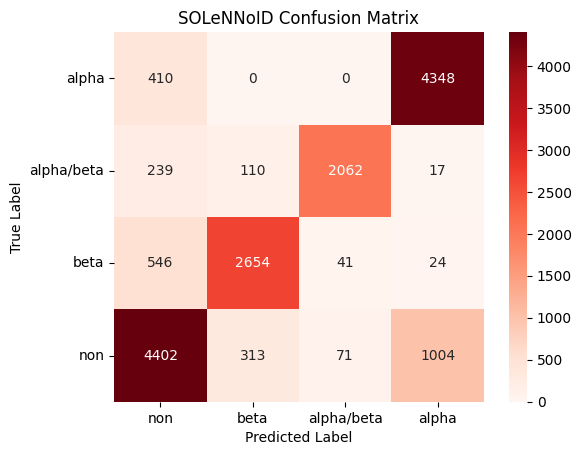

In [50]:
cm=confusion_matrix(testset_gt, testset_predictions_argmaxed)
sns.heatmap(cm[::-1],cmap='Reds',square=True,annot=True,fmt='.0f')
plt.xticks([0.5,1.5,2.5,3.5],['non','beta','alpha/beta','alpha'])
plt.yticks([3.5,2.5,1.5,0.5],['non','beta','alpha/beta','alpha'],rotation='horizontal')
plt.title("SOLeNNoID Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#plt.savefig("solennoid_cm_solenoid_mar2024_full_dataset.png", dpi=600, pad_inches=0.2, bbox_inches='tight')
plt.show()

#### TAPO Confusion Matrix

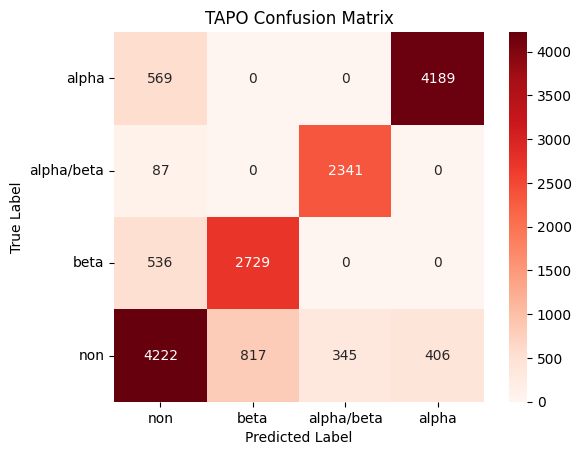

In [52]:
cm=confusion_matrix(testset_gt, tapo_preds)
sns.heatmap(cm[::-1],cmap='Reds',square=True,annot=True,fmt='.0f')
plt.xticks([0.5,1.5,2.5,3.5],['non','beta','alpha/beta','alpha'])
plt.yticks([3.5,2.5,1.5,0.5],['non','beta','alpha/beta','alpha'],rotation='horizontal')
plt.title("TAPO Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#plt.savefig("solennoid_cm_solenoid_mar2024_full_dataset.png", dpi=600, pad_inches=0.2, bbox_inches='tight')
plt.show()

#### RepeatsDB-Lite Confusion Matrix

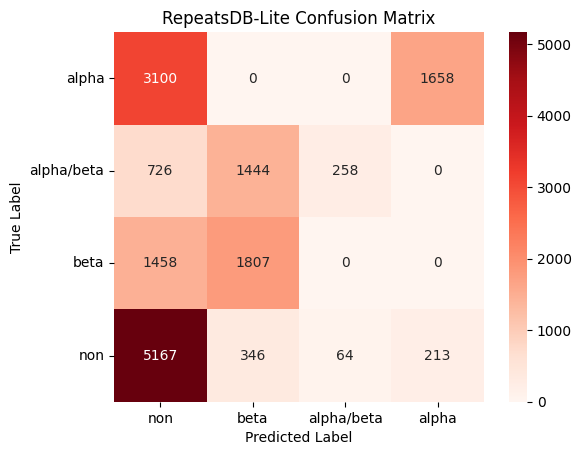

In [53]:
cm=confusion_matrix(testset_gt, rdb_lite_preds)
sns.heatmap(cm[::-1],cmap='Reds',square=True,annot=True,fmt='.0f')
plt.xticks([0.5,1.5,2.5,3.5],['non','beta','alpha/beta','alpha'])
plt.yticks([3.5,2.5,1.5,0.5],['non','beta','alpha/beta','alpha'],rotation='horizontal')
plt.title("RepeatsDB-Lite Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#plt.savefig("solennoid_cm_solenoid_mar2024_full_dataset.png", dpi=600, pad_inches=0.2, bbox_inches='tight')
plt.show()

#### PRIGSA2 Confusion Matrix

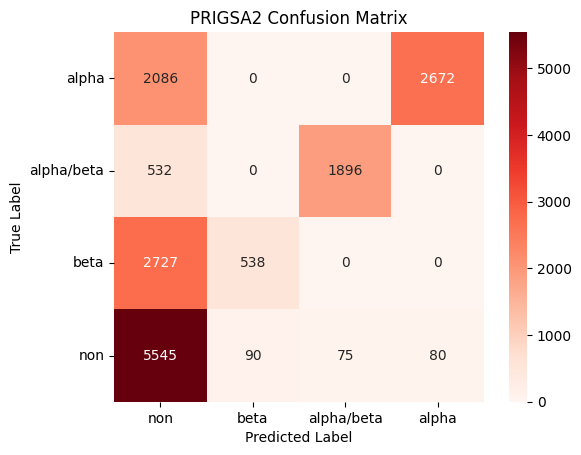

In [19]:
cm=confusion_matrix(testset_gt, prigsa2_preds)
sns.heatmap(cm[::-1],cmap='Reds',square=True,annot=True,fmt='.0f')
plt.xticks([0.5,1.5,2.5,3.5],['non','beta','alpha/beta','alpha'])
plt.yticks([3.5,2.5,1.5,0.5],['non','beta','alpha/beta','alpha'],rotation='horizontal')
plt.title("PRIGSA2 Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#plt.savefig("solennoid_cm_solenoid_mar2024_full_dataset.png", dpi=600, pad_inches=0.2, bbox_inches='tight')
plt.show()

#### SOLeNNoID Confusion Matrix (Full Testset)

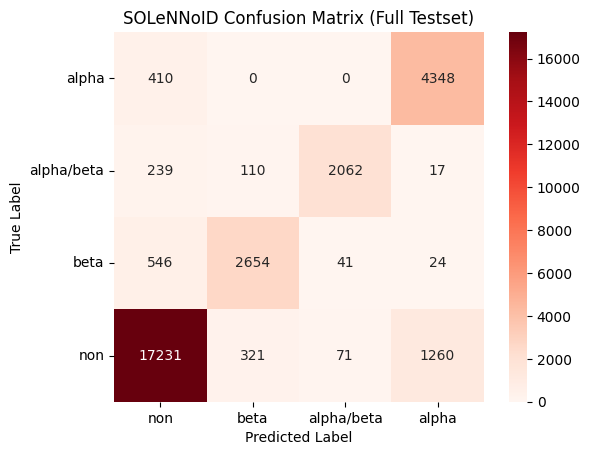

In [58]:
cm=confusion_matrix(testset_gt, testset_predictions_argmaxed)
sns.heatmap(cm[::-1],cmap='Reds',square=True,annot=True,fmt='.0f')
plt.xticks([0.5,1.5,2.5,3.5],['non','beta','alpha/beta','alpha'])
plt.yticks([3.5,2.5,1.5,0.5],['non','beta','alpha/beta','alpha'],rotation='horizontal')
plt.title("SOLeNNoID Confusion Matrix (Full Testset)")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#plt.savefig("solennoid_cm_solenoid_mar2024_full_dataset.png", dpi=600, pad_inches=0.2, bbox_inches='tight')
plt.show()